# Assignment 12: Radial Basis Function Network

In this assignment, we show an alternative learning strategy that has been forgotten in the last few years but might get more popularity in the near future.
A radial basis function layer has some similarities with a fully-connected layer, but the outputs of the layer are not determined by a dot product between the weights and the input but rather by computing a distance.
Unfortunately, `PyTorch` does not provide us with an implementation of an RBF layer, so we need to implement our own.
Additionally, the activation function is replaced by a function that creates higher outputs for small absolute inputs, such as a Gaussian distribution:

$$a_r = ||\vec w_r - \vec x\|^2 $$
$$h_r = e^{-\frac{a_r^2}{2 \sigma_r^2}}$$


Finally, we want to combine the convolutional network with an RBF layer and a final fully-connected layer to compute the 10 outputs.
For simplicity, let us define $K$ as the input dimension of our RBF layer, $R$ as the number of basis functions (the number of outputs) of our RBF layer, and $O=10$ as the number of outputs (logits) of our network.
The complete network topology is given below.
We are both interested in the deep feature representation that is the output of the first fully-connected layer and in the logits that are output from the second fully-connected layer.

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2
2. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
3. Activation function ReLU
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2
5. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
6. Activation function ReLU
7. Flatten layer to convert the convolution output into a vector
8. Fully-connected layer with the correct number of inputs and $K$ outputs
9. RBF layer with $K$ inputs and $R$ outputs (implemented in Task 2)
10. RBF activation function (implemented in Task 3)
11. Fully-connected layer with $R$ inputs and $O$ outputs

## Dataset

We will train and test our methods on the MNIST dataset.

### Task 1: Dataset

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation sets.

In [1]:
# https://gist.github.com/kdubovikov/eb2a4c3ecadd5295f68c126542e59f0a
import torch
import torchvision
from torch.utils.data import DataLoader

# define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # convert image to pytorch tensor
    torchvision.transforms.Normalize((0.1307,),(0.3081,)) # normalise inputs
])

# training set and data loader
train_set = torchvision.datasets.MNIST('.', download=True, train=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# validation set and data loader
validation_set = torchvision.datasets.MNIST('.', download=True, train=False, transform=transform)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 9912422/9912422 [00:00<00:00, 328386579.18it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 36519654.45it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 169940323.29it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3938500.88it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Radial Basis Function

We will split our implementation into three different parts.
First, we implement the output $a_r$ as provided above.
Second, we implement the activation function $h_r$.
Finally, we build our network by inserting an RBF layer in between the fully-connected layers of our default network.

In order to implement the output $a_k$ of the RBF layer, we will use a weight matrix $\mathbf W\in \mathbb R^{R\times K} = \left[\vec w_1, \vec w_2,\ldots, \vec w_R \right]$ where each vector is of dimension $K$.
When handling batches $\mathbf X \in \mathbb R^{B\times K}$, we require to compute our activations as:

  $$\mathbf A \in \mathbb R^{B\times R} = (a_{n,r}) \qquad \text{with} \qquad a_{n,r} =  \bigl\|\vec w_r - \vec x^{[n]}\bigr\|^2 = \sum\limits_{k=1}^K \bigl\|w_{r,k} - \vec x_r^{[n]}\bigr\|^2$$

In order to speed up processing and enable the use of `tensor` operations, we need to bring $\mathbf W$ and $\mathbf X$ to the same size $\mathbb R^{B\times R\times K}$ by logically (**not physically!**) copying the data and the weights to $\mathcal W$ and $\mathcal X$.
Then, the resulting $ \mathcal A = || \mathcal W - \mathcal X||$ needs to be summed up over dimension $K$ to arrive at $\mathbf A$ as given above.


### Task 2: Radial Basis Function Layer

Implement the RBF layer in PyTorch that computes the activation $\mathbf A$ of a radial basis function. Derive your layer from `torch.nn.Module`.
In the `__init__` function, instantiate the weight matrix $\mathbf W$ as a `torch.nn.Parameter`, and initialize the weight values randomly from values in range $[-2,2]$.
In `forward`, compute and return the activation from the stored weight matrix and the given input batch as indicated above.


In [2]:
class RBFLayer(torch.nn.Module):
  def __init__(self, K, R):
    # call base class constructor
    super(RBFLayer, self).__init__()
    # store a parameter for the basis functions
    self.W = torch.nn.Parameter(torch.empty((R, K)))
    # initialize the matrix between -2 and 2
    torch.nn.init.normal_(self.W, -2, 2)

  def forward(self, x):
    # collect the required shape parameters, B, R, K
    B, R, K = x.shape[0], self.W.shape[0], x.shape[1]
    # Bring the weight matrix of shape R,K to size B,R,K by adding batch dimension (B, dim 0)
    W = self.W.unsqueeze(dim=0).expand((B, R, K))
    # Bring the input matrix of shape B,K to size B,R,K by adding R dimension (dim=1)
    X = x.unsqueeze(dim=1).expand((B, R, K))
    # compute the activation / sum over dimension K
    A = torch.sum((W-X)**2, dim=2)
    return A

### Task 3: Radial Basis Function Activation

The activation function also requires a `Parameter`, i.e., the standard deviations of the Gaussian.
Hence, we need to implement the activation function also as a `torch.nn.Module`.
Here, we are treating the denominator of the Gaussian as a separate variable: `sigma2 = 2*sigma*sigma`.

Implement the activation function with learnable `sigma2` parameters.
Initialize all `sigma` parameters with the value of 1.




In [3]:
class RBFActivation(torch.nn.Module):
  def __init__(self, R):
    # call base class constructor
    super(RBFActivation, self).__init__()
    # store a parameter for the basis functions
    sigma = torch.nn.Parameter(torch.ones(R))
    self.sigma2 = 2*sigma*sigma
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Move parameters to the appropriate device
    self.sigma2 = self.sigma2.to(self.device)

  def forward(self, x):
    # implement the RBF activation function
    x = x.to(self.device)
    output = torch.exp(-x/self.sigma2)
    return output

### Test 1: RBF Layer and Activation

We instantiate an RBF layer and an RBF activation function for $K=4$ and $R=12$ and generate a random batch of size $B=16$.
We call both the RBF layer and the activation on the batch, and make sure that the resulting output is of shape $B\times R$.
This test also assures that the layers above are functioning and do not raise exceptions.

In [4]:
# instantiate layer and activation
test_RBF_layer = RBFLayer(K=4, R=12)
test_RBF_activation = RBFActivation(R=12)

# create test data batch
test_data = torch.empty((16,4))

# forward test data through the layer and the activation
a = test_RBF_layer(test_data)
h = test_RBF_activation(a)

# check that the shape is correct
assert h.shape == (16,12)

### Task 4: Radial Basis Function Network

As the network, we rely on our convolutional network from Assignment 8.
However, this time we add an RBF layer and its activation between the first and the second fully-connected layer.
We will return both the deep features of dimension $K$ and the logits of dimension $O$ in `forward`, which we will use later for visualization purposes.
Note that the processing will happen on batch level.




In [5]:
class RBFNetwork(torch.nn.Module):
  def __init__(self, Q1, Q2, K, R, O):
    # call base class constrcutor
    super(RBFNetwork,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(1, Q1, kernel_size=(5,5), stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, kernel_size=(5,5), stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.act = torch.nn.ReLU()
    # define first fully-connected layer
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(Q2*7*7, K, bias=True)
    # define RBF layer and its activation
    self.rbf_layer = RBFLayer(K, R)
    self.rbf_activation = RBFActivation(R)
    # define second fully-connected layer
    self.fc2 = torch.nn.Linear(R, O, bias=False)

  def forward(self,x):
    x = self.act(self.pool(self.conv1(x)))
    x = self.act(self.pool(self.conv2(x)))
    x = self.flatten(x)
    # get the deep feature layer as the output of the first fully-connected layer
    deep_feature = self.fc1(x)
    # apply the RBF layer and activation
    x = self.rbf_activation(self.rbf_layer(deep_feature))
    # apply the last fully-connected layer to obtain the logits
    logits = self.fc2(x)
    # return both the logits and the deep features
    return logits, deep_feature


### Task 5: Training and Validation Loop

The training and validation loops are as usual.
Instantiate the network with $Q_1=64$, $Q_2=32$, $K=2$, $R=100$ and $O=10$.
Instantiate loss function and optimizer.
Train the network on the training set.
Compute the validation set accuracy after each epoch of training.

Hints:

* The validation set accuracy after the first epoch should be more than 80%. If it is much lower, increase the learning rate and/or change the optimizer.
* On the other hand, if the accuracy gets stuck around 10% and does not change over the epochs, reduce the learning rate.
* The training on the GPU might take several minutes. On the CPU, training times might be increased.

In [6]:
def training_loop(network):
  optimizer = torch.optim.Adam(
    params=network.parameters(), lr=0.001
  )
  loss = torch.nn.CrossEntropyLoss()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  network = network.to(device)

  for epoch in range(20):
    accuracy_train = 0
    for x,t in train_loader:
      x, t = x.to(device), t.to(device)
      # train network with the current batch
      optimizer.zero_grad()
      z, _ = network(x)
      # loss + backpropagarion
      J = loss(z, t)
      J.backward(retain_graph=True)
      # perform update
      optimizer.step()
      # compute train accuracy
      accuracy_train += torch.sum(torch.argmax(z, dim=1) == t).item()

    # compute validation set accuracy
    accuracy_valid = 0
    network.eval()
    with torch.no_grad():
      for x,t in validation_loader:
        x, t = x.to(device), t.to(device)
        # forward
        z, _ = network(x)
        # compute validation accuracy
        accuracy_valid += torch.sum(torch.argmax(z, dim=1) == t).item()

    print(F"Epoch {epoch+1}: train accuracy: {accuracy_train/len(train_set):1.4f} test accuracy: {accuracy_valid/len(validation_set):1.4f}")

In [7]:
# instantiate RBFnetwork and train model
network = RBFNetwork(Q1=64, Q2=32, K=2, R=100, O=10)
training_loop(network)

Epoch 1: train accuracy: 0.8417 test accuracy: 0.9497
Epoch 2: train accuracy: 0.9481 test accuracy: 0.9545
Epoch 3: train accuracy: 0.9584 test accuracy: 0.9601
Epoch 4: train accuracy: 0.9647 test accuracy: 0.9595
Epoch 5: train accuracy: 0.9687 test accuracy: 0.9589
Epoch 6: train accuracy: 0.9715 test accuracy: 0.9560
Epoch 7: train accuracy: 0.9748 test accuracy: 0.9631
Epoch 8: train accuracy: 0.9760 test accuracy: 0.9562
Epoch 9: train accuracy: 0.9784 test accuracy: 0.9669
Epoch 10: train accuracy: 0.9788 test accuracy: 0.9656
Epoch 11: train accuracy: 0.9804 test accuracy: 0.9648
Epoch 12: train accuracy: 0.9821 test accuracy: 0.9679
Epoch 13: train accuracy: 0.9826 test accuracy: 0.9661
Epoch 14: train accuracy: 0.9846 test accuracy: 0.9666
Epoch 15: train accuracy: 0.9845 test accuracy: 0.9675
Epoch 16: train accuracy: 0.9846 test accuracy: 0.9665
Epoch 17: train accuracy: 0.9861 test accuracy: 0.9603
Epoch 18: train accuracy: 0.9860 test accuracy: 0.9673
Epoch 19: train acc

### (Optional) Task 5a:

Consider the minimum number for $R$, and use this number to train the model.

In [8]:
# instantiate RBFnetwork and train model
network_minimal = RBFNetwork(Q1=64, Q2=32, K=2, R=10, O=10)
training_loop(network_minimal)

Epoch 1: train accuracy: 0.3704 test accuracy: 0.4155
Epoch 2: train accuracy: 0.5096 test accuracy: 0.5775
Epoch 3: train accuracy: 0.6424 test accuracy: 0.7492
Epoch 4: train accuracy: 0.8115 test accuracy: 0.8556
Epoch 5: train accuracy: 0.8672 test accuracy: 0.8702
Epoch 6: train accuracy: 0.9294 test accuracy: 0.9616
Epoch 7: train accuracy: 0.9752 test accuracy: 0.9666
Epoch 8: train accuracy: 0.9784 test accuracy: 0.9696
Epoch 9: train accuracy: 0.9822 test accuracy: 0.9642
Epoch 10: train accuracy: 0.9847 test accuracy: 0.9696
Epoch 11: train accuracy: 0.9856 test accuracy: 0.9616
Epoch 12: train accuracy: 0.9874 test accuracy: 0.9657
Epoch 13: train accuracy: 0.9887 test accuracy: 0.9695
Epoch 14: train accuracy: 0.9901 test accuracy: 0.9681
Epoch 15: train accuracy: 0.9906 test accuracy: 0.9634
Epoch 16: train accuracy: 0.9905 test accuracy: 0.9724
Epoch 17: train accuracy: 0.9916 test accuracy: 0.9707
Epoch 18: train accuracy: 0.9909 test accuracy: 0.9674
Epoch 19: train acc

## Visualization
We have selected the dimensionality of the deep features to be $K=2$ in order to be able to visualize them.
The goal is to extract the deep feature representations of all validation samples.
For each sample, we regard the 2D representation as a point in a 2D space, which we can mark with a color that is dependent on the label of that sample.
After plotting a dot for each of the validation samples, we can observe if we find some structure in the feature space.

Finally, also the learned basis functions $\vec w_r$ can be plotted, including their according to size $\sigma_r$.
This allows us to see whether the RBF network has adapted itself to the data.

### Task 6: Deep Feature Extraction

Iterate through the validation set samples and extract the 2D deep feature representations for the images.
Store the results in 10 different lists, one for each target class.

In [9]:
def get_features(network):
  # extract all deep features for all validation set samples
  features = [[] for _ in range(10)]

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  network = network.to(device)

  with torch.no_grad():
    for x,t in validation_loader:
      # extract deep features
      x, t = x.to(device), t.to(device)
      _, deep_features = network(x)
      # separate the 10 different targets into separate lists
      for idx, target in enumerate(t):
        features[target].append(torch.tensor(deep_features[idx].to('cpu').detach()))

  # convert features to 2D for later processing/plotting
  features = [torch.stack(f) for f in features]
  return features

In [10]:
# call the function to get the deep features
features = get_features(network)

<ipython-input-9-abe70e0dd1c5>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[target].append(torch.tensor(deep_features[idx].to('cpu').detach()))


### (Optional) Task 6a: Deep Feature Extraction for `network_minimal`
Follow the exact same setup as Task 6.

In [11]:
# get the deep features from the network_minimal
features_minimal = get_features(network_minimal)

<ipython-input-9-abe70e0dd1c5>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[target].append(torch.tensor(deep_features[idx].to('cpu').detach()))


### Task 7: Deep Feature Visualization & Task 8: Basis Function Visualization

We provide a list of 10 different colors, one for each digit class.
For each of the 10 digits, plot all the samples in a 2D plot in the according color as a dot, maybe using `pyplot.scatter`.

Obtain the basis functions that were learned during network training from the layer implemented in Task 2.
Obtain the scaling factor $\sigma_r$ for each of the basis functions that were learned by the activation function layer from Task 3.
For each of the basis functions $\vec w_r$, draw a black circle with a radius corresponding to `sigmas`, which is computed from `sigma2` as follows:
$$\mathrm{sigmas} = \sqrt\frac{\mathrm{sigma2}}{2}$$
Overlay the plot from Task 7 with these circles.

Notes:

* The `s=` parameter to the `scatter` function is given in pts, so you might need to scale those values to be visible.
* Since each notebook cell uses its own drawing process, we need to combine Tasks 7 and 8 here.
* An example for $R=100$ can be found from exercise -- obtaining the shown legend is more difficult and does not need to be replicated.

In [36]:
import numpy
from matplotlib import pyplot
from matplotlib.patches import Patch

def plot(features, network):
  # define 10 visually distinct colors
  colors = numpy.array([
      [230, 25, 75],
      [60, 180, 75],
      [255, 225, 25],
      [67, 99, 216],
      [245, 130, 49],
      [145, 30, 180],
      [70, 240, 240],
      [240, 50, 230],
      [188, 246, 12],
      [250, 190, 190],
  ]) / 255.


  # generate 10 scatter plots inside the same figure, one for each label
  for i in range(10):
    pyplot.scatter(features[i][:,0], features[i][:,1], color = colors[i], label = f'{i}', s=0.5)

  # get the basis functions from the rbf layer
  basis_functions = network.rbf_layer.W.to('cpu').detach().numpy()
  # get the sizes from the rbf activation
  sigma2 = network.rbf_activation.sigma2.to("cpu").detach().numpy()
  sigmas = numpy.square(sigma2/2)

  # plot learned centers
  legend = pyplot.scatter(basis_functions[:,0], basis_functions[:,1],
                          color="k", marker="o", s=sigmas*100, facecolors="none", label='BF')

  # make the plot more beatuiful
  pyplot.legend()

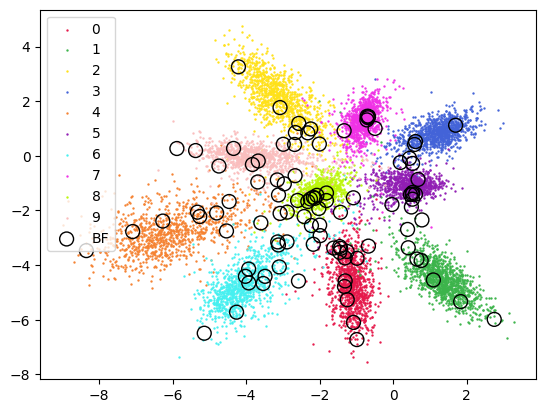

In [37]:
# call plot function and plot the result
plot(features, network)

### (Optional) Task 7a: Deep Feature Visualization & Task 8: Basis Function Visualization for another network

Follow the exact same setup as Task 7. This time, plot results for `network_minimal`.

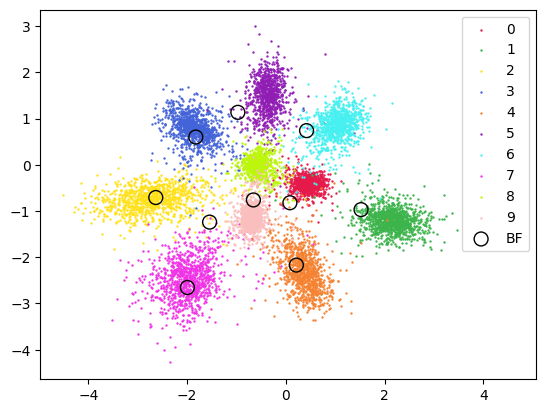

In [31]:
# instantiate plot function and plot the result
plot(features_minimal, network_minimal)